# Expectation maximization


In [ ]:
import numpy as np

In [3]:
# load data
def get_train_data():
    train_data = []
    with open("traindata.txt", "r") as file:
        for line in file:
            values = list(map(int, line.split()))

            train_data.append(values.copy())

    # return last col for feature vals
    return np.asarray(train_data, dtype=np.float64)

def get_test_data():
    test_data = []
    with open('testdata.txt', 'r') as file:
        for line in file:
            values = list(map(int, line.split()))

            test_data.append(values)

    return np.asarray(test_data, dtype=np.float32)

In [ ]:
from itertools import product
class EM:
    def __init__(self):
        self.xs = [0, 1, 2]
        self.ss= [0, 1]
        self.fs = [0, 1]
        self.ds = [0, 1]
        self.gs = [0, 1]

        self.pxt = {0: 0.5, 1: 0.25, 2: 0.25}
        self.pgt = {0: 0.9, 1: 0.1}
        self.psgxt = {
            0: {0: 0.02, 1: 0.8, 2: 0.8},
            1: {0: 0.01, 1: 0.1, 2: 0.1}
        }
        self.pfxt = {0: 0.02, 1: 0.85, 2: 0.60}
        self.pdxt = {0: 0.02, 1: 0.60, 2: 0.85}

        # construct probability table 
        self.p_table = self.construct_em_tbl()
        self.it_total_prev = -1

    def shuffle_noises(self, delta):
        ds = [self.pxt, self.pgt, self.psgxt[0], self.psgxt[1], self.pfxt, self.pdxt]
        for d in ds:
            self.add_noise(d, delta)
    
    def add_noise(self, d, delta):
        rand = [np.random.uniform(0, delta) for _ in d.keys()]
        total = np.sum(rand)

        keys = list(d.keys())
        for i in range(len(keys)):
            d[keys[i]] = (d[keys[i]] + rand[i]) / (1 + total)
    
    def construct_em_tbl(self):
        '''
        Returns the table of probabilities 
        '''
        res = []
        for s, f, d, g in list(product(self.ss, self.fs, self.ds, self.gs)):
            total_pxgsfd = 0
            temp = []
            for x in self.xs:
                psgx = s * self.psgxt[g][x] + (1 - s) * (1 - self.psgxt[g][x])
                pfx = f * self.pfxt[x] + (1 - f) * (1 - self.pfxt[x])
                pdx = d * self.pdxt[x] + (1 - d) * (1 - self.pdxt[x])
                pg = self.pgt[g]
                px = self.pxt[x]
                pxgsfd = px * pg * psgx * pfx * pdx
                total_pxgsfd += pxgsfd

                # last el is placeholder
                temp.append([s, f, d, g, x, px, pg, psgx, pfx, pdx, pxgsfd, -1])
            
            # normalize vs total 
            for t in range(len(temp)):
                temp[t][-1] = temp[t][-2] / total_pxgsfd

            res = res + temp

        return np.asarray(res, dtype=np.float64)
    
    def train(self, train_data):
        while True:
            self.p_table = self.construct_em_tbl()

            res = []
            for d in train_data:
                # get corresponding row in tbl
                match_idx = np.where(np.all(self.p_table[:, :4] == d[:4], axis=1))
                match = self.p_table[match_idx]

                if d[-1] != -1:
                    match[:, -1] = 0
                    match[match[:, 4] == d[-1], -1] = 1 

                # s, f, d, g, x, pxgsfd, fin
                select_cols = [0, 1, 2, 3, 4, 10, 11]
                res += match[:, select_cols].tolist()


            res = np.asarray(res)
            it_total = np.sum(res[:, -2])

            if it_total and abs(it_total - self.it_total_prev) < 0.01:
                break
            else:
                self.it_total_prev = it_total

            # update x weights
            for i in self.xs:
                xupdate = res[res[:, 4] == i]
                self.pxt[i] = np.sum(xupdate[:, -1]) / np.sum(res[:, -1])
            
            # update g weights
            for i in self.gs:
                gupdate = res[res[:, 3] == i]
                self.pgt[i] = np.sum(gupdate[:, -1]) / np.sum(res[:, -1])
            
            # update s weights
            for g in self.psgxt:
                for x in self.psgxt[g]:
                    s_total = res[(res[:, 3] == g) & (res[:, 4] == x)]
                    s_frac = s_total[s_total[:, 0] == 1] # assume s is true
                    self.psgxt[g][x] = np.sum(s_frac[:, -1]) / np.sum(s_total[:, -1])

            # update f weights 
            for x in self.pfxt:
                f_total = res[res[:, 4] == x]
                f_frac = f_total[f_total[:, 1] == 1] # assume f is true
                self.pfxt[x] = np.sum(f_frac[:, -1]) / np.sum(f_total[:, -1])
            
            # update d weights 
            for x in self.pdxt:
                d_total = res[res[:, 4] == x]
                d_frac = d_total[d_total[:, 2] == 1] # assume d is true
                self.pdxt[x] = np.sum(d_frac[:, -1]) / np.sum(d_total[:, -1])

    def predict(self, test_data):
        res = []
        self.p_table = self.construct_em_tbl()
        for feature in test_data:
            match = np.where(np.all(self.p_table[:, :4] == feature, axis=1))
            res.append(np.argmax(self.p_table[match][:, -1]))
        return np.asarray(res)

em = EM()
probs = em.construct_em_tbl()

In [ ]:
    em = EM()
    train_data = get_train_data()
    em.train(train_data)
    test_data = get_test_data()
    features = test_data[:, :4]
    target = test_data[:, 4]
    res = em.predict(features)
    np.sum(np.asarray(res) == target) / len(target)

0.93

# 2. add noise and do 20 trials


In [19]:
from tqdm import tqdm 

train_data = get_train_data()
test_data = get_test_data()
features = test_data[:, :4]
target = test_data[:, 4]

deltas = np.linspace(0, 4, 20)
iters = 20
res = []
for delta in tqdm(deltas):
    for i in tqdm(range(iters), leave=False):
        em = EM()
        em.shuffle_noises(delta)
        pre_em_preds = em.predict(features)
        pre_em_acc = np.sum(np.asarray(pre_em_preds) == target) / len(target)
        em.train(train_data)
        preds = em.predict(features)
        acc = np.sum(np.asarray(preds) == target) / len(target)
        res.append({"delta": delta, "iter": i, "em_acc": acc, "pre_em_acc": pre_em_acc})

100%|██████████| 20/20 [14:17<00:00, 42.87s/it]


In [20]:
import pandas as pd
df = pd.DataFrame(res)

In [22]:
df_temp = df.groupby(by=['delta']).agg(['mean', 'std'])

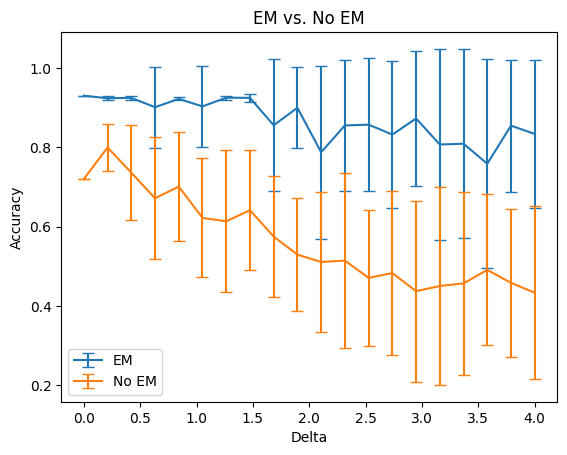

In [26]:
import matplotlib.pyplot as plt

# plt.plot(deltas, df_temp[('em_acc', 'mean')])
plt.errorbar(deltas, df_temp[('em_acc', 'mean')], yerr=df_temp[('em_acc', 'std')], capsize=4, label='EM')
plt.errorbar(deltas, df_temp[('pre_em_acc', 'mean')], yerr=df_temp[('pre_em_acc', 'std')], capsize=4, label='No EM')
plt.title("EM vs. No EM")
plt.xlabel("Delta")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
df_temp[('em_acc', 'mean')]

delta
0.000000    0.9300
0.210526    0.9235
0.421053    0.9245
0.631579    0.9010
0.842105    0.9220
1.052632    0.9030
1.263158    0.9250
1.473684    0.9245
1.684211    0.8555
1.894737    0.8995
2.105263    0.7875
2.315789    0.8550
2.526316    0.8570
2.736842    0.8320
2.947368    0.8725
3.157895    0.8070
3.368421    0.8090
3.578947    0.7585
3.789474    0.8545
4.000000    0.8335
Name: (em_acc, mean), dtype: float64